In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
train_weather = pd.read_parquet('/app/data/train_with_weather_cleaned_20240514.parquet', engine='fastparquet')
test_weather = pd.read_parquet('/app/data/test_with_weather_cleaned_20240514.parquet', engine='fastparquet')

# Drop 'Date' from both train and test datasets
train_weather = train_weather.drop('Date', axis=1)
test_weather = test_weather.drop('Date', axis=1)

train_weather = train_weather.drop('Year', axis=1)
test_weather = test_weather.drop('Year', axis=1)

# Separate the target variable
X_train = train_weather.drop('WnvPresent', axis=1)
y_train = train_weather['WnvPresent']

# Split training data into training and validation
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_train, y_train, test_size=.3, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_o, y_train_o, test_size=.3, random_state=42)

# Ensures each fold is representative of the overall class distribution
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# AdaBoostClassifier performed best on the resampled set using the default model.
model = AdaBoostClassifier()

# Balance classes using SMOTEENN. Oversamples the minority class and undersamples the majority class
print(f'Original dataset shape {Counter(y_train_b)}')
X_train_b_float = X_train_b.astype(float)
oversample = SMOTEENN(random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train_b_float, y_train_b)
print(f'Resampled dataset shape {Counter(y_resampled)}')

Original dataset shape Counter({0: 4866, 1: 281})
Resampled dataset shape Counter({1: 4280, 0: 4142})


Metrics with 1 features - ROC AUC: 0.5375, Precision: 0.0716, Recall: 0.3269, F1 Score: 0.1174
Metrics with 2 features - ROC AUC: 0.6660, Precision: 0.1327, Recall: 0.1250, F1 Score: 0.1287
Metrics with 3 features - ROC AUC: 0.8122, Precision: 0.1723, Recall: 0.4904, F1 Score: 0.2550
Metrics with 4 features - ROC AUC: 0.8048, Precision: 0.1893, Recall: 0.3750, F1 Score: 0.2516
Metrics with 5 features - ROC AUC: 0.8594, Precision: 0.2169, Recall: 0.5673, F1 Score: 0.3138
Metrics with 6 features - ROC AUC: 0.8718, Precision: 0.2190, Recall: 0.5769, F1 Score: 0.3175
Metrics with 7 features - ROC AUC: 0.8782, Precision: 0.2271, Recall: 0.5481, F1 Score: 0.3211
Metrics with 8 features - ROC AUC: 0.8720, Precision: 0.2305, Recall: 0.5673, F1 Score: 0.3278
Metrics with 9 features - ROC AUC: 0.8706, Precision: 0.2519, Recall: 0.6346, F1 Score: 0.3607
Metrics with 10 features - ROC AUC: 0.8738, Precision: 0.2254, Recall: 0.5288, F1 Score: 0.3161
Metrics with 11 features - ROC AUC: 0.8687, Preci

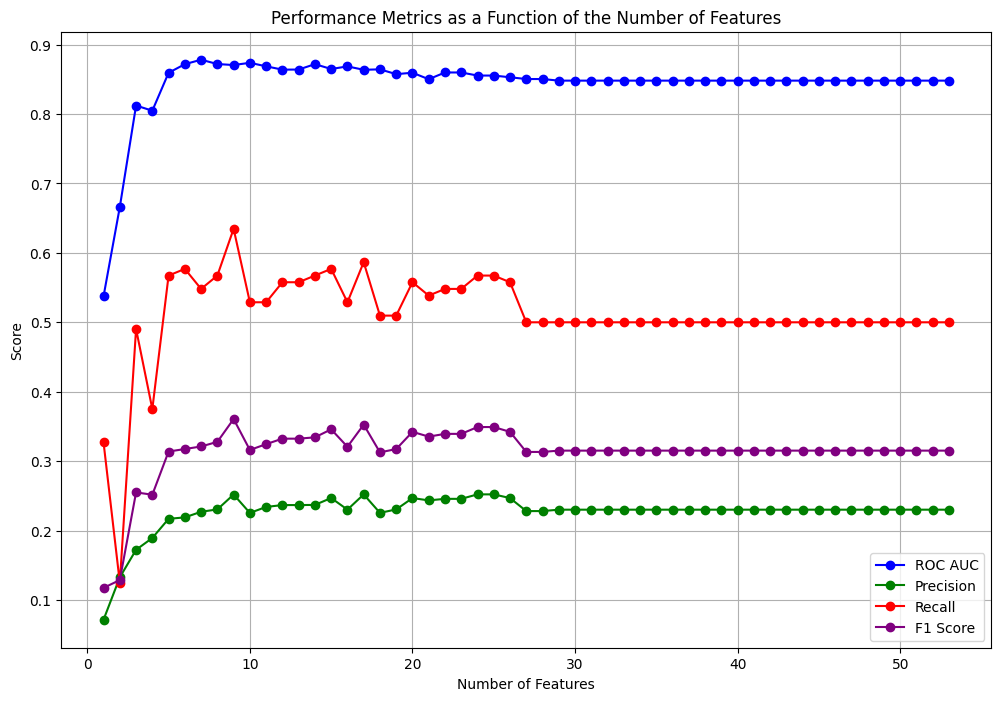

In [3]:
base_model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100, learning_rate=1.0, random_state=42)

# Initialize RFE with the base model but without specifying n_features_to_select
selector = RFE(estimator=base_model, step=1, verbose=0)

# Evaluate the performance and log the results
metrics = {
    'n_features': [],
    'f1_scores': [],
    'roc_auc_scores': [],
    'precision_scores': [],
    'recall_scores': []
}

for i in range(1, X_resampled.shape[1] + 1):
    # Move to the next step of feature elimination
    
    selector.n_features_to_select = i

    # Fit RFE
    selector.fit(X_resampled, y_resampled)

    X_resampled_reduced = selector.transform(X_resampled)
    X_val_b_reduced = selector.transform(X_val_b)
    
    reduced_model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100, learning_rate=1.0, random_state=42)
    reduced_model.fit(X_resampled_reduced, y_resampled)
    predictions_reduced = reduced_model.predict(X_val_b_reduced)
    probabilities_reduced = reduced_model.predict_proba(X_val_b_reduced)[:, 1]

    # Calculate all metrics
    roc_auc = roc_auc_score(y_val_b, probabilities_reduced)
    precision = precision_score(y_val_b, predictions_reduced)
    recall = recall_score(y_val_b, predictions_reduced)
    f1 = f1_score(y_val_b, predictions_reduced)

    # Store metrics
    metrics['n_features'].append(i)
    metrics['f1_scores'].append(f1)
    metrics['roc_auc_scores'].append(roc_auc)
    metrics['precision_scores'].append(precision)
    metrics['recall_scores'].append(recall)
    
    print(f"Metrics with {i} features - ROC AUC: {roc_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## Plotting the results for all metrics on a single graph
plt.figure(figsize=(12, 8))

# Plot each metric with a different color and label
plt.plot(metrics['n_features'], metrics['roc_auc_scores'], marker='o', label='ROC AUC', color='blue')
plt.plot(metrics['n_features'], metrics['precision_scores'], marker='o', label='Precision', color='green')
plt.plot(metrics['n_features'], metrics['recall_scores'], marker='o', label='Recall', color='red')
plt.plot(metrics['n_features'], metrics['f1_scores'], marker='o', label='F1 Score', color='purple')

# Adding title, labels, legend, and grid
plt.title('Performance Metrics as a Function of the Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [6]:
# Initialize RFE with the base model and desired number of features
selector = RFE(estimator=base_model, n_features_to_select=9, step=1, verbose=0)

# Fit RFE
selector.fit(X_resampled, y_resampled)

# Get the support and ranking of the features
print("Features sorted by their rank:")
for r, f in sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X_resampled.columns)):
    print(f'{f}: {r}')

# Transform the data to reduced feature set
X_resampled_reduced = selector.transform(X_resampled)
X_val_b_reduced = selector.transform(X_val_b)

# Train and evaluate the model on reduced features for validation
reduced_model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100, learning_rate=1.0, random_state=42)
reduced_model.fit(X_resampled_reduced, y_resampled)

predictions_reduced = reduced_model.predict(X_val_b_reduced)
probabilities_reduced = reduced_model.predict_proba(X_val_b_reduced)[:, 1]

# Calculate all metrics
roc_auc = roc_auc_score(y_val_b, probabilities_reduced)
precision = precision_score(y_val_b, predictions_reduced)
recall = recall_score(y_val_b, predictions_reduced)
f1 = f1_score(y_val_b, predictions_reduced)

print(f"Metrics - ROC AUC: {roc_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Features sorted by their rank:
AddressAccuracy: 1
Day_of_Week: 1
Location_Cluster: 1
NumMosquitos: 1
PrecipTotal_lag1: 1
SeaLevel: 1
Species: 1
Sunrise: 1
wnv_case_proportion: 1
WetBulb_7day_avg: 2
mosquito_proportion: 3
Latitude: 4
Week_of_Year: 5
Tmax: 6
Block: 7
Longitude: 8
Day_of_Month: 9
Depart: 10
wnv_case_proportion_alt: 11
ResultSpeed_7day_avg: 12
StnPressure_7day_avg: 13
AvgSpeed_7day_avg: 14
DewPoint_lag1: 15
Month: 16
Trap: 17
Tmax_7day_avg: 18
DewPoint_7day_avg: 19
ResultDir: 20
AvgSpeed: 21
Tmin_7day_avg: 22
Day_of_Year: 23
PrecipTotal_7day_avg: 24
ResultDir_lag1: 25
StnPressure_lag1: 26
ResultSpeed: 27
ResultSpeed_lag1: 28
AvgSpeed_lag1: 29
DewPoint: 30
ResultDir_7day_avg: 31
WetBulb: 32
Tavg_lag1: 33
Heat: 34
Tavg_7day_avg: 35
WetBulb_lag1: 36
Tmin_lag1: 37
Tmax_lag1: 38
Cool: 39
Tmin: 40
StnPressure: 41
Tavg: 42
PrecipTotal: 43
Sunset: 44
SnowFall: 45
Metrics - ROC AUC: 0.8706, Precision: 0.2519, Recall: 0.6346, F1 Score: 0.3607


In [5]:
### GRID SEARCH HYPERPARAMETERS ###

# Grid search parameters
param_grid = {
    'n_estimators': [50, 100, 150, 200], # default: 100
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0], # default: 1.0,
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=0)

# Fit grid search on the resampled dataset
grid_search.fit(X_resampled_reduced, y_resampled)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1):", grid_search.best_score_)

# Optionally, validate the best model on the held-out test data
best_model = grid_search.best_estimator_

probs = best_model.predict_proba(X_val_b_reduced)[:, 1]
predictions = best_model.predict(X_val_b_reduced)

# Calculating metrics
roc_auc = roc_auc_score(y_val_b, probs)
precision = precision_score(y_val_b, predictions)
recall = recall_score(y_val_b, predictions)
f1 = f1_score(y_val_b, predictions)
conf_mat = confusion_matrix(y_val_b, predictions)

metrics = {
    'ROC AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Confusion Matrix': conf_mat
}

for k, v in metrics.items():
    print(f'\n{k}: \n{v}')

Best parameters: {'learning_rate': 1.5, 'n_estimators': 200}
Best cross-validation score (F1): 0.971671449205727

ROC AUC: 
0.8630276345147957

Precision: 
0.2413793103448276

Recall: 
0.40384615384615385

F1 Score: 
0.302158273381295

Confusion Matrix: 
[[1971  132]
 [  62   42]]
